# Progetto di Intelligenza Artificiale 2: Classificazione di Skillshot in Rocket League

**Autori:**
*   William Carradori (Matricola: 1914036)
*   Salvatore Piccione (Matricola: 2069571)

**Corso:** Intelligenza Artificiale 2 - A.A. 2025/2026

---

## 1. Introduzione e Obiettivo del Progetto

### 1.1. Contesto e Obiettivo
In questo progetto applichiamo le tecniche di machine learning viste nel corso a un problema di classificazione nel mondo dei videogiochi competitivi: *Rocket League*. L'obiettivo è costruire un modello capace di riconoscere quale "skillshot" (manovra avanzata) sta eseguendo un giocatore, partendo unicamente dai dati grezzi di telemetria del gioco.

Si tratta di un problema di **classificazione supervisionata**, dove le etichette (i nomi delle manovre) sono note a priori.

### 1.2. Il Dato Grezzo: Serie Temporali
La sfida principale di questo dataset risiede nella sua natura: i dati sono **serie temporali multivariate**. Ogni manovra è descritta da una sequenza di frame di durata variabile, che descrive l'evoluzione dello stato del veicolo, della palla e degli input del giocatore.

Questo ci impone di trovare una strategia per trasformare le sequenze in un formato a lunghezza fissa, prima di poter applicare i modelli di classificazione standard studiati.

### 1.3. Ambiente di Lavoro
Iniziamo importando le librerie necessarie per l'analisi e impostando un `seed` per garantire la riproducibilità dei nostri risultati.

In [ ]:
# Importazione delle librerie standard per l'analisi dati e la visualizzazione
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gdown
import os

# Importazione dei moduli specifici di scikit-learn che useremo
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.dummy import DummyClassifier


# Configurazione dello stile dei grafici per uniformità nel report
sns.set_theme(style="whitegrid", context="notebook")

# Impostazione del seed per la riproducibilità dei risultati (Best Practice)
np.random.seed(42)

print("Librerie importate e ambiente configurato.")

Librerie importate e ambiente configurato.


## 2. Acquisizione e Strutturazione dei Dati

### 2.1. Parsing del Formato Originale

Il dataset originale è fornito come un singolo file di testo (`.data`) che non ha una struttura tabulare standard (come un CSV). I dati sono organizzati in blocchi sequenziali: una riga con l'etichetta della classe è seguita da N righe, ognuna rappresentante un frame temporale della manovra.

Questo formato non è direttamente utilizzabile da librerie come `pandas`. Per questo motivo, abbiamo implementato un parser personalizzato con i seguenti compiti:
1.  Leggere il file riga per riga.
2.  Riconoscere le righe di etichetta per identificare l'inizio di una nuova sequenza.
3.  Associare a ogni frame di dati un **ID di sequenza** (`Sequence_ID`) e l'**etichetta della classe** (`Class_Label`) corrispondente.

L'obiettivo è ottenere un unico DataFrame in cui ogni riga rappresenta un singolo *frame* di gioco, arricchito con le informazioni contestuali necessarie per raggruppare i dati per manovra.

In [ ]:
def parse_raw_data(filepath):
    """
    Legge il file .data non strutturato e lo trasforma in un DataFrame pandas.

    Args:
        filepath (str): Il percorso del file .data da parsare.

    Returns:
        pandas.DataFrame: Un DataFrame strutturato con tutti i frame del gioco.
    """
    data_rows = []
    current_label = None
    sequence_counter = 0
    header = []

    with open(filepath, 'r') as f:
        lines = f.readlines()

        # La prima riga del file contiene l'header originale
        if len(lines) > 0:
            header = lines[0].strip().split()
            # Aggiungiamo le colonne che useremo per identificare le sequenze
            columns = ['Sequence_ID', 'Class_Label'] + header

        # Processiamo le righe di dati dalla seconda in poi
        for line in lines[1:]:
            parts = line.strip().split()
            if not parts: continue # Salta righe vuote

            # Se la riga contiene un solo elemento, è una nuova etichetta di classe
            if len(parts) == 1:
                current_label = int(parts[0])
                sequence_counter += 1
            # Altrimenti, è un frame di dati
            elif current_label is not None:
                row_values = [float(x) for x in parts]
                data_rows.append([sequence_counter, current_label] + row_values)

    return pd.DataFrame(data_rows, columns=columns)

# --- Esecuzione del caricamento e parsing ---

# 1. Download del dataset (se non è già presente)
output_filename = 'rocket_league_skillshots.data'
if not os.path.exists(output_filename):
    print(f"File {output_filename} non trovato. Inizio lo scaricamento...")
    file_id = '1GaCg_W8B6HGPBGMmcGVuvBhqceJ65k7A'
    url = f'https://drive.google.com/uc?id={file_id}'
    gdown.download(url, output_filename, quiet=False)
else:
    print(f"File {output_filename} già presente.")

# 2. Parsing del file e creazione del DataFrame
print("\nInizio il parsing del file...")
df_raw = parse_raw_data(output_filename)
print("Parsing completato.")

# 3. Verifica del risultato
print("-" * 30)
print(f"Numero totale di frame (righe): {df_raw.shape[0]}")
print(f"Numero totale di feature (colonne): {df_raw.shape[1]}")
print(f"Numero di manovre uniche (sequenze): {df_raw['Sequence_ID'].nunique()}")
print("Prime 5 righe del DataFrame:")
display(df_raw.head())

File rocket_league_skillshots.data non trovato. Inizio lo scaricamento...


Downloading...
From: https://drive.google.com/uc?id=1GaCg_W8B6HGPBGMmcGVuvBhqceJ65k7A
To: /content/rocket_league_skillshots.data
100%|██████████| 911k/911k [00:00<00:00, 9.56MB/s]



Inizio il parsing del file...
Parsing completato.
------------------------------
Numero totale di frame (righe): 6892
Numero totale di feature (colonne): 20
Numero di manovre uniche (sequenze): 298
Prime 5 righe del DataFrame:


,Sequence_ID,Class_Label,BallAcceleration,Time,DistanceWall,DistanceCeil,DistanceBall,PlayerSpeed,BallSpeed,up,accelerate,slow,goal,left,boost,camera,down,right,slide,jump
0,1,6,1636.798772,0.000000,3498.01,2012.98,299.668270,104267.426232,99035.849338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,1,6,3198.029397,0.138893,3494.08,2012.98,229.896780,124248.031988,102233.878734,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,1,6,0.000000,0.173617,3494.08,2012.98,237.350599,124248.031988,102968.358990,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,1,6,9914.766242,0.312510,3500.08,2012.98,151.880921,115248.016009,112883.125231,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,6,5907.747166,0.625019,3521.65,2013.00,154.556104,125091.256173,118790.872398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


## 3. Analisi Esplorativa dei Dati (EDA)

### 3.1. Obiettivi dell'EDA

Ora che i dati sono in un formato maneggevole, eseguiamo un'analisi esplorativa per rispondere ad alcune domande fondamentali che guideranno il nostro processo di modellazione:

1.  **Quante e quali manovre ci sono? Il dataset è bilanciato?** Capire la distribuzione delle classi è cruciale. Un forte sbilanciamento ci obbligherà a usare metriche di valutazione più appropriate dell'accuracy.
2.  **Quanto durano le sequenze? Hanno lunghezza costante?** Verificare la variabilità della durata delle manovre ci aiuterà a giustificare la necessità di una strategia di feature engineering per creare vettori a dimensione fissa.

### 3.2. Distribuzione delle Classi

Per prima cosa, mappiamo le etichette numeriche delle classi ai loro nomi corrispondenti, come specificato nella documentazione del dataset, per rendere i risultati più leggibili.

--- Distribuzione delle Classi (Conteggio per Manovra) ---
Class_Label
Power Shot      60
Front Flick     46
Air Dribble     45
Noise           43
Waving Dash     38
Musty Flick     36
Ceiling Shot    30
Name: count, dtype: int64


/tmp/ipython-input-270923404.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis", order=class_counts.index)


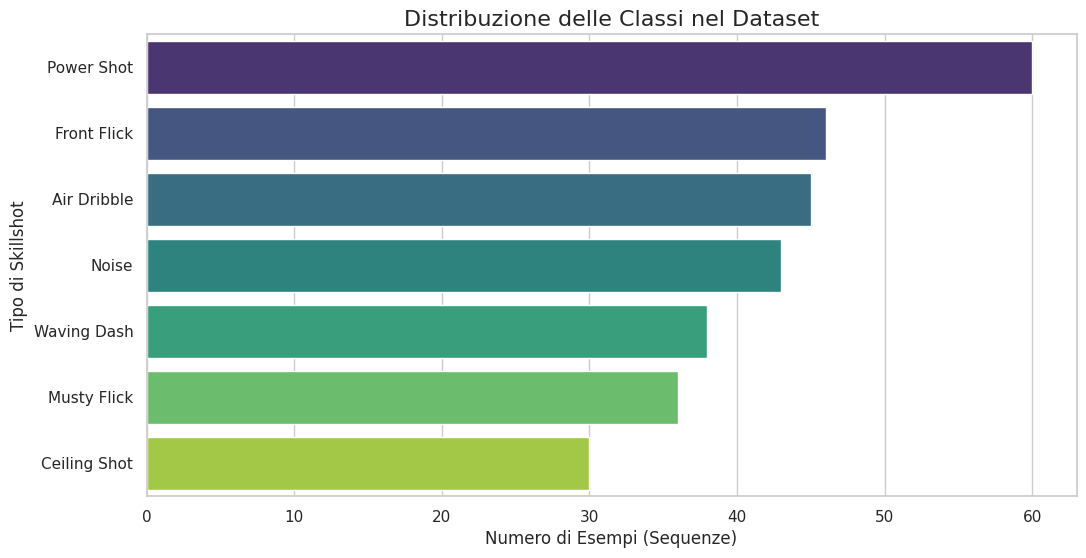

In [ ]:
# Mappatura delle etichette numeriche a nomi leggibili
label_map = {
    -1: 'Noise',
    1: 'Ceiling Shot',
    2: 'Power Shot',
    3: 'Waving Dash',
    5: 'Air Dribble',
    6: 'Front Flick',
    7: 'Musty Flick'
}

# Per contare le manovre, dobbiamo considerare le sequenze uniche, non i singoli frame.
# Raggruppiamo per Sequence_ID e prendiamo la prima etichetta di ciascun gruppo.
unique_sequences = df_raw.groupby('Sequence_ID')['Class_Label'].first()
class_counts = unique_sequences.map(label_map).value_counts()

print("--- Distribuzione delle Classi (Conteggio per Manovra) ---")
print(class_counts)

# Visualizzazione grafica per evidenziare il bilanciamento (o sbilanciamento)
plt.figure(figsize=(12, 6))
sns.barplot(x=class_counts.values, y=class_counts.index, palette="viridis", order=class_counts.index)
plt.title("Distribuzione delle Classi nel Dataset", fontsize=16)
plt.xlabel("Numero di Esempi (Sequenze)", fontsize=12)
plt.ylabel("Tipo di Skillshot", fontsize=12)
plt.show()

### 3.2.1. Commento sulla Distribuzione delle Classi

Il grafico e i conteggi confermano la presenza di un **moderato sbilanciamento** tra le classi. La classe più rappresentata, `Power Shot` (60 campioni), ha il doppio degli esempi della meno rappresentata, `Ceiling Shot` (30 campioni).

Questa osservazione è fondamentale per due motivi:
1.  **Scelta della Metrica:** Valutare i modelli usando la semplice *accuracy* sarebbe fuorviante. Un classificatore potrebbe ottenere un punteggio alto semplicemente imparando a riconoscere bene le classi più frequenti e ignorando quelle più rare. Per questo motivo, in fase di validazione, useremo l'**F1-score pesato (`f1_weighted`)**, una metrica robusta che tiene conto di questo sbilanciamento.
2.  **Presenza di "Rumore":** Notiamo che la classe `Noise` è una delle più frequenti (43 campioni). Questo rende il problema più realistico e complesso: il nostro modello non dovrà solo distinguere tra diverse manovre, ma anche essere in grado di scartare le sequenze di azioni che non corrispondono a nessuno skillshot definito.

### 3.3. Analisi della Durata delle Sequenze

Il secondo punto chiave della nostra EDA è analizzare la durata (in numero di frame) di ogni sequenza. I modelli di classificazione che utilizzeremo (come la Regressione Logistica) richiedono vettori di feature a lunghezza fissa. Dobbiamo quindi verificare se le nostre sequenze rispettano già questo vincolo o se, come sospettiamo, la loro lunghezza è variabile.

--- Statistiche sulla Durata delle Sequenze ---
Durata Minima: 4 frame
Durata Massima: 64 frame
Durata Media: 23.13 frame
Deviazione Standard: 10.38 frame


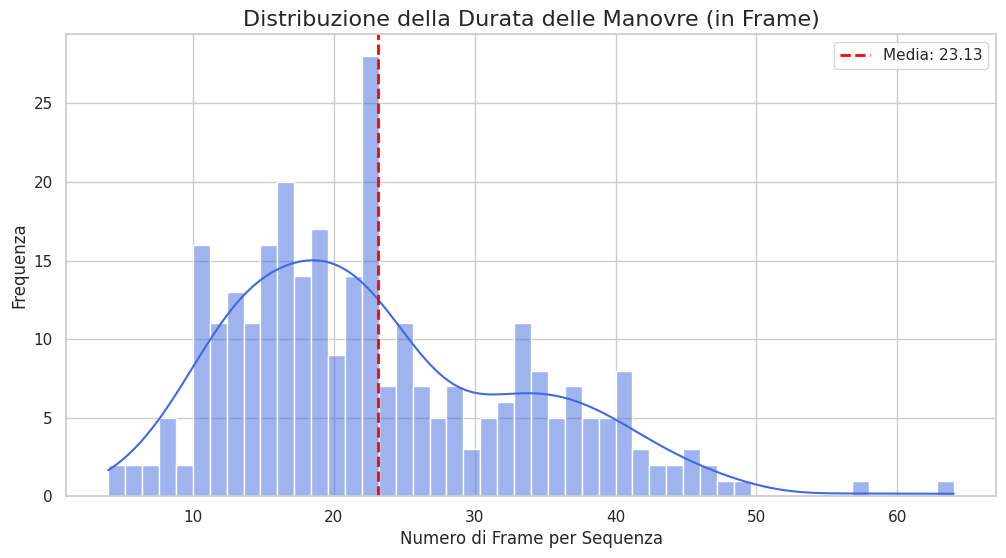

In [ ]:
# Calcolo della lunghezza (numero di frame) per ogni sequenza
seq_lengths = df_raw.groupby('Sequence_ID').size()

# Statistiche descrittive sulla durata
print("--- Statistiche sulla Durata delle Sequenze ---")
print(f"Durata Minima: {seq_lengths.min()} frame")
print(f"Durata Massima: {seq_lengths.max()} frame")
print(f"Durata Media: {seq_lengths.mean():.2f} frame")
print(f"Deviazione Standard: {seq_lengths.std():.2f} frame")

# Istogramma della distribuzione delle durate
plt.figure(figsize=(12, 6))
sns.histplot(seq_lengths, bins=50, kde=True, color='royalblue')
plt.title('Distribuzione della Durata delle Manovre (in Frame)', fontsize=16)
plt.xlabel('Numero di Frame per Sequenza', fontsize=12)
plt.ylabel('Frequenza', fontsize=12)
plt.axvline(seq_lengths.mean(), color='red', linestyle='--', linewidth=2, label=f'Media: {seq_lengths.mean():.2f}')
plt.legend()
plt.show()

### 3.3.1. Commento sulla Durata delle Sequenze

Come mostrato dalle statistiche descrittive e dall'istogramma, la lunghezza delle sequenze è **altamente variabile**. Le manovre possono durare da un minimo di 4 frame a un massimo di 64, con una media di circa 23 frame e una notevole deviazione standard.

Questa osservazione è il vincolo tecnico più importante del nostro progetto. Poiché gli algoritmi di classificazione che utilizzeremo (come Logistic Regression, LDA e KNN) richiedono in input una matrice di feature a dimensione fissa (ogni riga deve avere lo stesso numero di colonne), non possiamo usare direttamente le serie temporali.

Questa constatazione giustifica la necessità della fase successiva: il **Feature Engineering**, dove trasformeremo ogni sequenza di lunghezza variabile in un singolo vettore di feature a lunghezza fissa.

## 4. Feature Engineering e Analisi delle Feature Aggregate

### 4.1. Strategia di Aggregazione Statistica

Per trasformare ogni sequenza in un singolo vettore di feature, adottiamo una strategia di **aggregazione statistica**. L'idea è di riassumere l'intera evoluzione temporale di ciascuna variabile all'interno di una manovra calcolando alcune statistiche descrittive.

Tuttavia, le variabili nel nostro dataset non sono tutte uguali. Le dividiamo in due gruppi e applichiamo strategie di aggregazione differenti per massimizzare l'informazione estratta ed evitare problemi di collinearità:

1.  **Variabili Continue (es. `PlayerSpeed`, `DistanceBall`):** Per queste variabili, calcoliamo un set completo di statistiche per catturare sia la tendenza centrale che la dispersione e gli estremi del segnale:
    *   `mean`: Il valore medio, che indica l'intensità generale della feature.
    *   `std`: La deviazione standard, che misura la variabilità o "nervosismo" del segnale.
    *   `min` e `max`: I valori estremi, utili per identificare picchi (es. massima velocità raggiunta).
    *   `median`: La mediana, una misura di tendenza centrale più robusta agli outlier rispetto alla media.

2.  **Variabili Binarie (es. `boost`, `jump`):** Queste variabili rappresentano gli input del controller (0 per non premuto, 1 per premuto). Per queste, calcoliamo **solo la media (`mean`)**. La media di una variabile binaria ha un'interpretazione diretta e molto utile: rappresenta la **frazione di tempo** in cui il pulsante è stato premuto durante la sequenza. Calcolare altre statistiche sarebbe ridondante o dannoso: `min` e `max` sarebbero quasi sempre 0 e 1 (feature inutili), e la `std` sarebbe una funzione diretta della media, introducendo collinearità.

In [ ]:
def perform_feature_engineering(df):
    """
    Trasforma il DataFrame di frame grezzi in una matrice di feature X
    e un vettore target y a dimensione fissa.

    Args:
        df (pandas.DataFrame): Il DataFrame grezzo con i dati sequenziali.

    Returns:
        (pandas.DataFrame, numpy.ndarray): La matrice di feature X e il vettore y.
    """
    # 1. Definizione delle liste di colonne per tipo di aggregazione
    continuous_cols = [
        'BallAcceleration', 'Time', 'DistanceWall', 'DistanceCeil',
        'DistanceBall', 'PlayerSpeed', 'BallSpeed'
    ]
    binary_cols = [
        'up', 'accelerate', 'slow', 'goal', 'left', 'boost',
        'camera', 'down', 'right', 'slide', 'jump'
    ]

    # 2. Raggruppamento per sequenza
    grouped = df.groupby('Sequence_ID')

    # 3. Estrazione del vettore target y
    y = grouped['Class_Label'].first().values

    # 4. Aggregazione delle feature continue
    agg_funcs_cont = ['mean', 'std', 'min', 'max', 'median']
    X_cont = grouped[continuous_cols].agg(agg_funcs_cont)

    # Se una sequenza ha un solo frame, la sua dev. std. è NaN. La sostituiamo con 0.
    X_cont = X_cont.fillna(0)

    # Appiattiamo i nomi delle colonne da ('Feature', 'Stat') a 'Feature_Stat'
    X_cont.columns = ['_'.join(col) for col in X_cont.columns]

    # 5. Aggregazione delle feature binarie (solo media)
    X_bin = grouped[binary_cols].agg(['mean'])
    X_bin.columns = ['_'.join(col) for col in X_bin.columns]

    # 6. Unione dei due set di feature per creare la matrice finale X
    X = pd.concat([X_cont, X_bin], axis=1)

    return X, y

# --- Esecuzione del Feature Engineering ---
print("Esecuzione del Feature Engineering in corso...")
X, y = perform_feature_engineering(df_raw)
print("Feature Engineering completato.")
print("-" * 30)
print(f"Dimensioni della nuova matrice di feature X: {X.shape}")
print(f"Dimensioni del vettore target y: {y.shape}")
print("\nPrime 5 righe della matrice X:")
display(X.head())

Esecuzione del Feature Engineering in corso...
Feature Engineering completato.
------------------------------
Dimensioni della nuova matrice di feature X: (298, 46)
Dimensioni del vettore target y: (298,)

Prime 5 righe della matrice X:


,BallAcceleration_mean,BallAcceleration_std,BallAcceleration_min,BallAcceleration_max,BallAcceleration_median,Time_mean,Time_std,Time_min,Time_max,Time_median,...,accelerate_mean,slow_mean,goal_mean,left_mean,boost_mean,camera_mean,down_mean,right_mean,slide_mean,jump_mean
Sequence_ID,,,,,,,,,,,,,,,,,,,,,
1,-3853.867885,35679.993733,-195896.923082,33405.144871,0.000000,2.326591,1.487481,0.0,5.070104,2.205022,...,0.125000,0.031250,0.062500,0.000000,0.218750,0.062500,0.0,0.812500,0.218750,0.281250
2,-848.813985,25070.370116,-57692.175539,127059.240710,-440.381900,3.261104,2.471619,0.0,8.161284,2.639636,...,0.205128,0.025641,0.256410,0.076923,0.205128,0.102564,0.0,1.000000,0.461538,0.256410
3,-1264.766385,28249.873734,-89020.813365,124246.293754,-198.638061,3.453076,2.864376,0.0,8.130110,2.326575,...,0.264706,0.029412,0.088235,0.029412,0.294118,0.088235,0.0,1.000000,0.117647,0.205882
4,-2133.341430,9446.138278,-39930.029136,8232.787624,0.000000,1.612082,0.918998,0.0,3.610510,1.631764,...,0.478261,0.000000,0.000000,0.000000,0.304348,0.130435,0.0,1.000000,0.347826,0.478261
5,-7148.505767,31105.083894,-141736.497607,5120.925237,406.177646,1.311509,1.051272,0.0,3.681763,1.232506,...,0.318182,0.045455,0.000000,0.000000,0.363636,0.136364,0.0,0.727273,0.318182,0.227273


### 4.3. Analisi di Correlazione delle Feature Aggregate

Dopo aver creato le 46 feature aggregate, è fondamentale verificare la presenza di **multicollinearità**, ovvero la correlazione tra le feature stesse. Un'alta correlazione può rendere i modelli lineari (come Logistic Regression e LDA) instabili e i loro coefficienti difficili da interpretare.

Calcoliamo e visualizziamo la matrice di correlazione su questa nuova matrice `X` per identificare eventuali pattern.

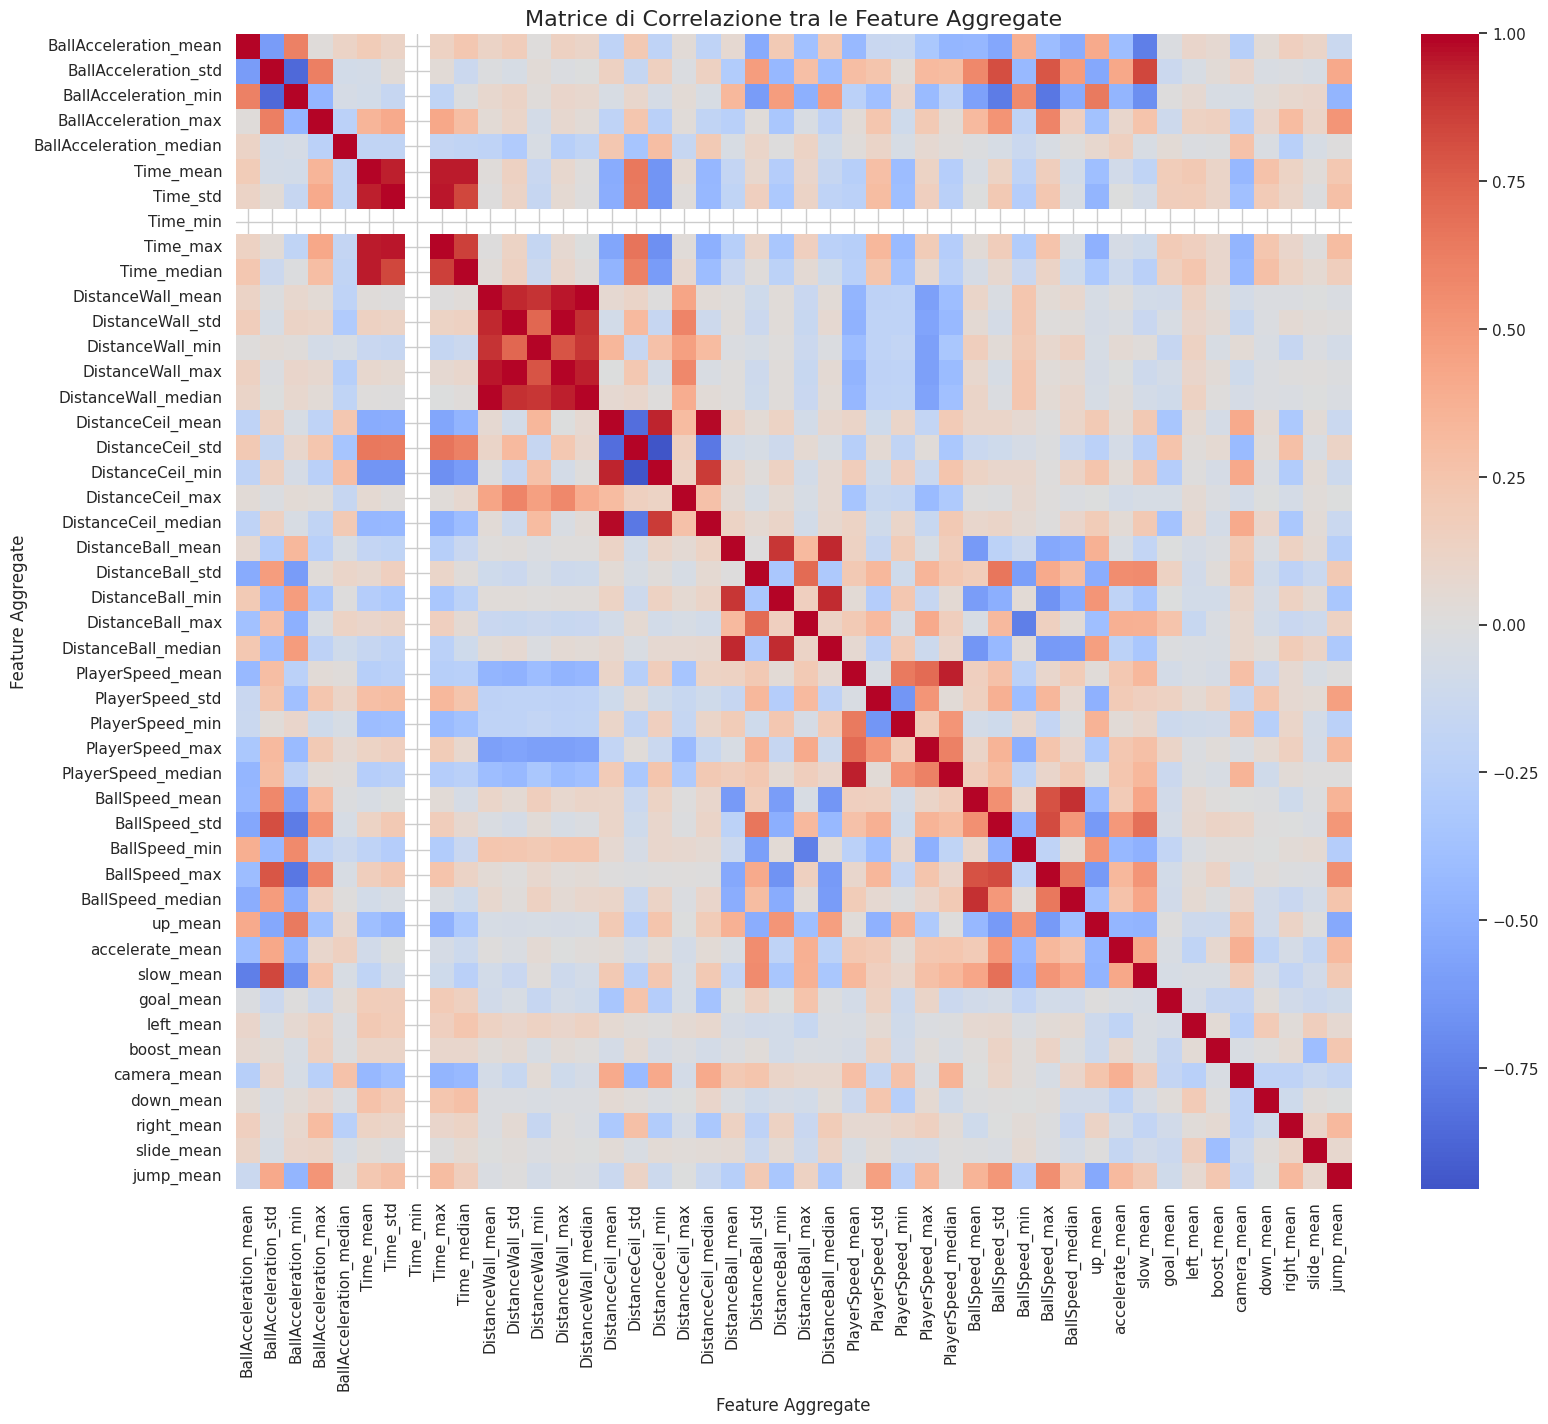

La heatmap mostra diversi blocchi di colore intenso (rosso o blu), indicando forti correlazioni.
Ad esempio, le statistiche derivate dalla stessa feature grezza (es. PlayerSpeed_mean, PlayerSpeed_std) sono spesso correlate tra loro.
Questa forte multicollinearità giustifica l'uso della PCA per creare un nuovo set di feature ortogonali e ridurre la ridondanza.


In [ ]:
# Calcolo della matrice di correlazione sulla matrice di feature X
corr_matrix_agg = X.corr()

# Visualizzazione tramite heatmap per una lettura più intuitiva
plt.figure(figsize=(18, 15))
sns.heatmap(corr_matrix_agg, cmap='coolwarm', center=0)
plt.title("Matrice di Correlazione tra le Feature Aggregate", fontsize=16)
plt.xlabel("Feature Aggregate")
plt.ylabel("Feature Aggregate")
plt.show()

# Commento sulle osservazioni
print("La heatmap mostra diversi blocchi di colore intenso (rosso o blu), indicando forti correlazioni.")
print("Ad esempio, le statistiche derivate dalla stessa feature grezza (es. PlayerSpeed_mean, PlayerSpeed_std) sono spesso correlate tra loro.")
print("Questa forte multicollinearità giustifica l'uso della PCA per creare un nuovo set di feature ortogonali e ridurre la ridondanza.")

## 5. Preparazione dei Dati per la Modellazione

### 5.1. Divisione Train/Test e Prevenzione del Data Leakage

Prima di addestrare qualsiasi modello o applicare trasformazioni che "imparano" dai dati (come la standardizzazione o la PCA), è metodologicamente cruciale dividere il nostro dataset in due parti:

1.  **Training Set (70%):** Utilizzato per addestrare i modelli e ottimizzare i loro iperparametri.
2.  **Test Set (30%):** Messo da parte e utilizzato **una sola volta** alla fine del processo, per valutare le performance del modello finale su dati completamente nuovi.

Questa separazione previene il **data leakage**, un errore comune in cui le informazioni del test set influenzano indirettamente l'addestramento del modello, portando a stime delle performance eccessivamente ottimistiche e non veritiere.

Dato che le nostre classi sono sbilanciate, useremo una **divisione stratificata** (`stratify=y`) per assicurarci che le proporzioni delle classi nel training set e nel test set rispecchino quelle del dataset originale.

In [ ]:
from sklearn.model_selection import train_test_split

# Divisione del dataset in Training (70%) e Test (30%)
# L'opzione stratify=y assicura che la distribuzione delle classi sia mantenuta in entrambi i set.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

print("--- Divisione del Dataset completata ---")
print(f"Dimensioni Training Set (X): {X_train.shape}")
print(f"Dimensioni Test Set (X):     {X_test.shape}")
print(f"Dimensioni Training Set (y): {y_train.shape}")
print(f"Dimensioni Test Set (y):     {y_test.shape}")

# Verifichiamo che la stratificazione abbia funzionato correttamente
print("\nDistribuzione percentuale delle classi nel set originale:")
print(pd.Series(y).value_counts(normalize=True).sort_index())
print("\nDistribuzione percentuale delle classi nel Training Set:")
print(pd.Series(y_train).value_counts(normalize=True).sort_index())

--- Divisione del Dataset completata ---
Dimensioni Training Set (X): (208, 46)
Dimensioni Test Set (X):     (90, 46)
Dimensioni Training Set (y): (208,)
Dimensioni Test Set (y):     (90,)

Distribuzione percentuale delle classi nel set originale:
-1    0.144295
 1    0.100671
 2    0.201342
 3    0.127517
 5    0.151007
 6    0.154362
 7    0.120805
Name: proportion, dtype: float64

Distribuzione percentuale delle classi nel Training Set:
-1    0.144231
 1    0.100962
 2    0.201923
 3    0.129808
 5    0.149038
 6    0.153846
 7    0.120192
Name: proportion, dtype: float64


## 6. Selezione e Ottimizzazione del Modello

In questa fase, il nostro obiettivo è identificare il miglior modello di classificazione per il nostro problema. Per farlo in modo metodologicamente corretto, seguiremo questi passaggi:
1.  **Incapsulare Preprocessing e Classificazione in Pipeline:** Per ogni modello, creeremo una `Pipeline` che esegue in sequenza la standardizzazione dei dati, la riduzione di dimensionalità con PCA e l'addestramento del classificatore. Questo approccio è fondamentale per evitare il *data leakage* durante la cross-validation.
2.  **Confrontare i Modelli con Cross-Validation:** Valuteremo le performance di diversi algoritmi (Logistic Regression, LDA, KNN) utilizzando una cross-validation a 5 fold stratificata sul training set.
3.  **Scegliere la Metrica Appropriata:** A causa dello sbilanciamento delle classi, useremo l'**F1-score pesato** (`f1_weighted`) come metrica principale per confrontare i modelli.
4.  **Ottimizzare gli Iperparametri:** Per il modello KNN, le cui performance dipendono fortemente dal numero di vicini (K), eseguiremo una ricerca per trovare il valore ottimale di K.

### 6.1. Costruzione delle Pipeline e Valutazione Comparativa

Definiamo le pipeline per i tre modelli candidati. Per la PCA, impostiamo `n_components=0.95`, chiedendo all'algoritmo di selezionare automaticamente il numero minimo di componenti principali necessarie per spiegare il 95% della varianza totale dei dati.

In [ ]:
# 1. Configurazione della strategia di Cross-Validation
# Usiamo 5 fold stratificati per mantenere la distribuzione delle classi in ogni fold.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Definizione delle Pipeline per ogni modello
# Ogni pipeline standardizza i dati, applica la PCA e poi addestra il classificatore.
pipelines = {
    'Logistic Regression': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('clf', LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'))
    ]),
    'LDA': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('clf', LinearDiscriminantAnalysis())
    ]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        # Iniziamo con un K di default (es. 5), che ottimizzeremo dopo.
        ('clf', KNeighborsClassifier(n_neighbors=5))
    ])
}

# 3. Esecuzione della Cross-Validation per confrontare i modelli
print("--- Risultati Cross-Validation (F1-score Weighted Medio) ---")
print("-" * 60)

results = {}
for name, pipe in pipelines.items():
    # Usiamo 'f1_weighted' come metrica di scoring
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='f1_weighted')
    results[name] = scores
    print(f"{name:20}: {scores.mean():.4f} (+/- {scores.std():.4f})")

# 4. Analisi della dimensionalità ridotta dalla PCA
# Creiamo una pipeline temporanea solo per vedere quante componenti vengono scelte
pca_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42))
])
# Fittiamo la pipeline sui dati di training per calcolare le componenti
pca_pipeline.fit(X_train)
n_components_selected = pca_pipeline.named_steps['pca'].n_components_

print("-" * 60)
print(f"Per spiegare il 95% della varianza, la PCA ha selezionato {n_components_selected} componenti principali.")
print(f"La dimensionalità è stata ridotta da {X_train.shape[1]} a {n_components_selected} feature.")

--- Risultati Cross-Validation (F1-score Weighted Medio) ---
------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was depre

Logistic Regression : 0.7761 (+/- 0.0469)
LDA                 : 0.7470 (+/- 0.0340)
KNN                 : 0.6997 (+/- 0.0791)
------------------------------------------------------------
Per spiegare il 95% della varianza, la PCA ha selezionato 20 componenti principali.
La dimensionalità è stata ridotta da 46 a 20 feature.


### 6.2. Analisi dei Risultati Preliminari

Dai risultati della cross-validation, emergono due osservazioni chiave:

1.  **Performance dei Modelli:** La **Regressione Logistica** (`F1-score: 0.7761`) si dimostra il modello più performante sul training set, superando sia LDA che KNN con i parametri di default. Questo suggerisce che, nello spazio a dimensionalità ridotta creato dalla PCA, le classi sono separabili in modo sufficientemente lineare.
2.  **Effetto della PCA:** La PCA ha ridotto efficacemente la dimensionalità del nostro problema, passando da 46 feature aggregate a sole **20 componenti principali**. Questo non solo velocizza l'addestramento, ma, riducendo la ridondanza, contribuisce a creare un modello più robusto e meno soggetto a overfitting.

### 6.3. Ottimizzazione degli Iperparametri (Tuning di K per KNN)

Mentre Logistic Regression e LDA hanno pochi iperparametri in questo contesto, le performance del KNN sono molto sensibili alla scelta del numero di vicini, $K$. Un valore di $K$ troppo basso può portare a overfitting, mentre un valore troppo alto può rendere il modello troppo semplice (*underfitting*).

Eseguiamo quindi una ricerca per trovare il valore ottimale di $K$, utilizzando sempre la cross-validation per valutare ogni scelta in modo robusto.

Inizio tuning di K per KNN (valori testati: [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29])...
----------------------------------------
Il miglior valore di K trovato è: 3
F1-score medio con K=3: 0.7442
----------------------------------------


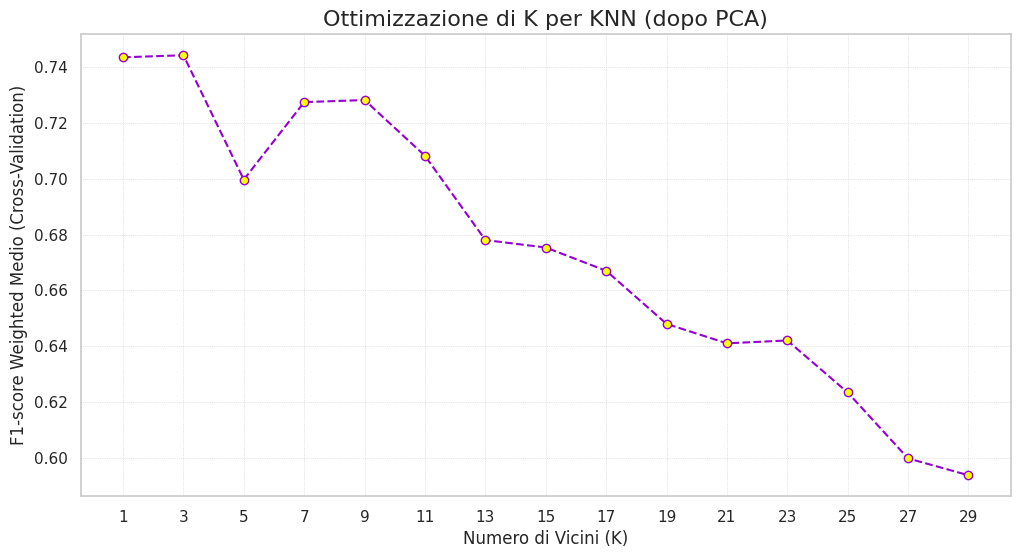

In [ ]:
# Definiamo un range di valori di K da testare (generalmente numeri dispari per evitare pareggi)
k_values = range(1, 31, 2)
k_scores = []

print(f"Inizio tuning di K per KNN (valori testati: {list(k_values)})...")

for k in k_values:
    # Creiamo una pipeline specifica per il valore di K corrente
    knn_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=0.95, random_state=42)),
        ('clf', KNeighborsClassifier(n_neighbors=k))
    ])

    # Eseguiamo la cross-validation
    scores = cross_val_score(knn_pipeline, X_train, y_train, cv=cv, scoring='f1_weighted')
    k_scores.append(scores.mean())

# Identifichiamo il valore di K che ha dato il punteggio medio più alto
best_k_index = np.argmax(k_scores)
best_k = k_values[best_k_index]
best_score = k_scores[best_k_index]

print("-" * 40)
print(f"Il miglior valore di K trovato è: {best_k}")
print(f"F1-score medio con K={best_k}: {best_score:.4f}")
print("-" * 40)

# Visualizziamo i risultati per capire l'andamento
plt.figure(figsize=(12, 6))
plt.plot(k_values, k_scores, marker='o', linestyle='--', color='darkviolet', mfc='yellow')
plt.title('Ottimizzazione di K per KNN (dopo PCA)', fontsize=16)
plt.xlabel('Numero di Vicini (K)', fontsize=12)
plt.ylabel('F1-score Weighted Medio (Cross-Validation)', fontsize=12)
plt.xticks(k_values)
plt.grid(True, which='both', linestyle=':', linewidth=0.5)
plt.show()

### 6.4. Scelta del Modello Finale

I risultati del nostro processo di selezione sono chiari:
*   **Logistic Regression:** `F1-score = 0.7761`
*   **LDA:** `F1-score = 0.7470`
*   **KNN (ottimizzato con K=3):** `F1-score = 0.7442`

Il grafico del tuning di KNN mostra che le performance migliori si ottengono per valori di K molto bassi (K=1 e K=3), per poi degradare costantemente all'aumentare del numero di vicini. Questo suggerisce che i confini decisionali sono abbastanza locali e complessi.

Nonostante l'ottimizzazione, **la Regressione Logistica rimane il modello con le performance migliori** stimate in cross-validation. Pertanto, la selezioniamo come nostro "champion model" per la valutazione finale.

## 7. Valutazione Finale sul Test Set

Siamo giunti alla fase conclusiva del nostro progetto. Ora utilizzeremo il **Test Set**, che è stato tenuto completamente isolato fino a questo momento, per ottenere una stima finale e imparziale delle performance del nostro miglior modello.

Il processo è il seguente:
1.  Prendiamo la pipeline della **Regressione Logistica**, che abbiamo identificato come la più performante.
2.  La addestriamo sull'**intero Training Set** per sfruttare al massimo i dati a nostra disposizione.
3.  Eseguiamo le predizioni sul **Test Set**.
4.  Calcoliamo le metriche di valutazione finali (F1-score, Classification Report) e le confrontiamo con quelle di un **`DummyClassifier`**, che predice sempre la classe più frequente. Questo confronto ci dirà quanto il nostro modello è realmente "intelligente" rispetto a una strategia banale.

Addestramento del modello finale (Logistic Regression) su tutto il training set...
Addestramento completato.

--- PERFORMANCE FINALI SUL TEST SET ---
F1-score Weighted (Modello Finale): 0.8114
F1-score Weighted (Baseline Stratified): 0.1649
--------------------------------------------------

Classification Report Dettagliato:
              precision    recall  f1-score   support

       Noise      0.600     0.692     0.643        13
Ceiling Shot      1.000     0.556     0.714         9
  Power Shot      0.895     0.944     0.919        18
 Waving Dash      1.000     1.000     1.000        11
 Air Dribble      0.929     0.929     0.929        14
 Front Flick      0.818     0.643     0.720        14
 Musty Flick      0.600     0.818     0.692        11

    accuracy                          0.811        90
   macro avg      0.834     0.797     0.802        90
weighted avg      0.833     0.811     0.811        90



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


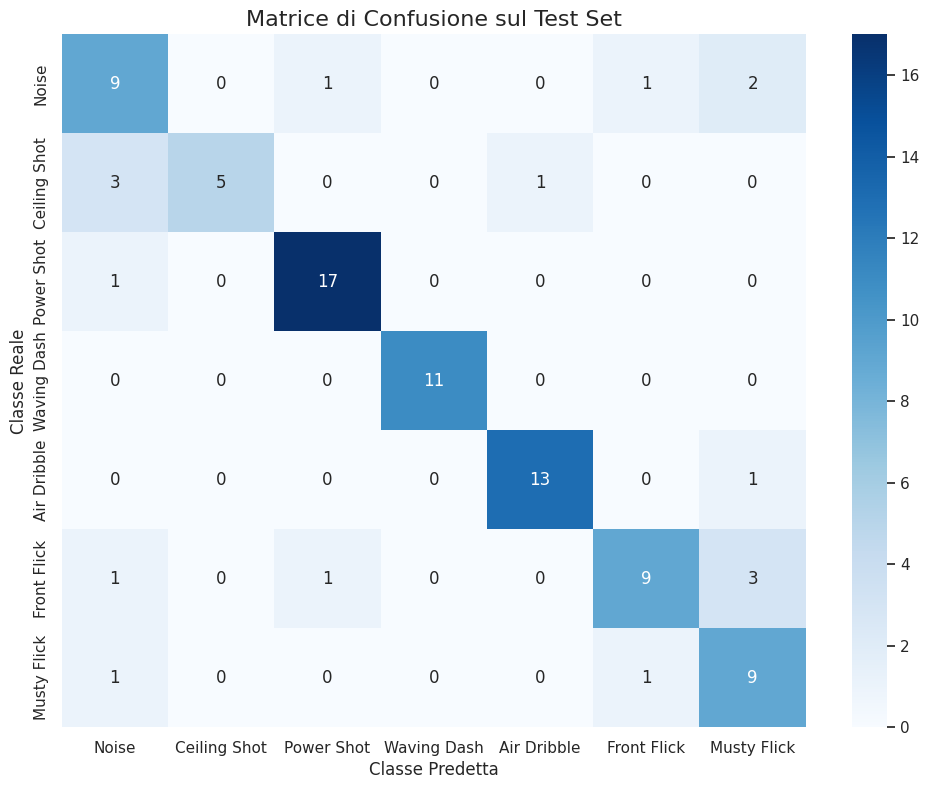

In [ ]:
# 1. Definizione della pipeline finale con il modello scelto
final_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000, random_state=42, multi_class='ovr'))
])

# 2. Addestramento del modello finale sull'intero training set
print("Addestramento del modello finale (Logistic Regression) su tutto il training set...")
final_pipeline.fit(X_train, y_train)
print("Addestramento completato.")

# 3. Esecuzione delle predizioni sul test set
y_pred = final_pipeline.predict(X_test)

# 4. Creazione e valutazione della baseline (Dummy Classifier)
dummy_clf = DummyClassifier(strategy="stratified", random_state=42) # 'stratified' predice in base alla distribuzione
dummy_clf.fit(X_train, y_train)
y_dummy = dummy_clf.predict(X_test)

# 5. Calcolo delle metriche finali
f1_model = f1_score(y_test, y_pred, average='weighted')
f1_dummy = f1_score(y_test, y_dummy, average='weighted')

print("\n--- PERFORMANCE FINALI SUL TEST SET ---")
print(f"F1-score Weighted (Modello Finale): {f1_model:.4f}")
print(f"F1-score Weighted (Baseline Stratified): {f1_dummy:.4f}")
print("-" * 50)

# 6. Report di classificazione dettagliato
# Otteniamo i nomi delle classi ordinati per il report
unique_labels_in_test = sorted(list(set(y_test)))
target_names = [label_map[label] for label in unique_labels_in_test]

print("\nClassification Report Dettagliato:")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

# 7. Matrice di Confusione
cm = confusion_matrix(y_test, y_pred, labels=unique_labels_in_test)

plt.figure(figsize=(12, 9))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice di Confusione sul Test Set', fontsize=16)
plt.ylabel('Classe Reale', fontsize=12)
plt.xlabel('Classe Predetta', fontsize=12)
plt.show()

## 8. Discussione dei Risultati e Conclusioni

### 8.1. Analisi della Performance Finale

Il nostro obiettivo era sviluppare un modello in grado di classificare gli skillshot di Rocket League partendo da dati grezzi. La valutazione finale sul test set, mai visto prima, ci permette di quantificare il successo del nostro approccio.

**Il modello finale (Regressione Logistica preceduta da Standardizzazione e PCA) ha ottenuto un F1-score pesato di 0.8114.**

Questo risultato è estremamente positivo se confrontato con la **baseline casuale stratificata**, che ottiene un F1-score di appena **0.1649**. Il nostro modello fornisce quindi un guadagno informativo enorme, dimostrando di aver imparato pattern significativi dai dati e di essere in grado di generalizzare su sequenze nuove.

Analizzando il `Classification Report` e la `Matrice di Confusione`, possiamo trarre conclusioni più dettagliate:

*   **Classi Riconosciute con Eccellenza:** Il modello è quasi perfetto nel riconoscere `Waving Dash` (F1-score di 1.000), `Power Shot` (0.919) e `Air Dribble` (0.929). Queste manovre, evidentemente, hanno una "firma" statistica molto chiara e distintiva che il nostro feature engineering è riuscito a catturare efficacemente.

*   **Classi con Margini di Miglioramento:** Le performance sono buone ma non perfette per `Front Flick` e `Musty Flick`. Dalla matrice di confusione, notiamo che il modello tende a confondere queste due classi tra loro (3 `Front Flick` classificati come `Musty Flick`, e 1 `Musty Flick` come `Front Flick`). Questo è prevedibile, poiché sono entrambe variazioni di un "flick" e potrebbero condividere dinamiche simili nelle fasi iniziali.

*   **Criticità Principali:**
    *   **`Ceiling Shot`:** Questa classe ha una `precision` perfetta (1.000) ma una `recall` di solo 0.556. Questo significa che *quando il modello predice un Ceiling Shot, è quasi sempre corretto*, ma *non riesce a identificare quasi la metà dei Ceiling Shot reali*, confondendoli principalmente con `Noise` o `Air Dribble`. Probabilmente, la fase di volo che caratterizza questa manovra non è catturata a sufficienza dalle nostre statistiche aggregate.
    *   **`Noise`:** La classe `Noise` ha la `precision` più bassa (0.600). Questo indica che il modello tende a classificare erroneamente alcune manovre reali come rumore, come si vede dalle righe della matrice di confusione.

### 8.2. Limiti e Conclusioni Finali

Questo progetto dimostra che, anche con modelli lineari relativamente semplici, è possibile affrontare un problema complesso come la classificazione di serie temporali in ambito videoludico, a patto di eseguire un'attenta fase di feature engineering.

Il limite principale del nostro approccio è che l'aggregazione statistica **perde completamente l'informazione sull'ordine temporale** degli eventi all'interno di una manovra. Un `jump` seguito da un `boost` viene trattato allo stesso modo di un `boost` seguito da un `jump`. Metodi più avanzati potrebbero analizzare direttamente la sequenza, potenzialmente migliorando il riconoscimento delle classi più complesse.

In conclusione, abbiamo costruito una pipeline di machine learning completa e metodologicamente corretta, che trasforma dati grezzi, seleziona il modello migliore tramite cross-validation e ne valuta le performance in modo robusto, ottenendo un classificatore efficace e significativamente migliore di una baseline casuale.